In [25]:
import pandas as pd

file_path = "data/data.txt"

df = pd.read_csv(file_path, delimiter="\t")
print("Column names:", df.columns)

df.columns = df.columns.str.strip()

df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

df['Gain/Loss'] = df['Close'] - df['Open']

df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')

print(df.head())

specific_row = df[df['Date'] == '2023-12-11']
print(specific_row)

Column names: Index(['Date', 'Open', 'High', 'Low', 'Close ', ' Adj Close ', ' Volume'], dtype='object')
        Date    Open    High     Low   Close  Adj Close      Volume  Gain/Loss
0 2024-10-28  153.50  155.20  150.61  150.69     150.69  20846600.0      -2.81
1 2024-10-25  156.20  157.48  154.52  155.01     155.01   8153000.0      -1.19
2 2024-10-24  152.61  155.89  151.98  155.20     155.20   9774400.0       2.59
3 2024-10-23  160.00  161.47  153.53  157.06     157.06  15931500.0      -2.94
4 2024-10-22  160.50  160.66  158.37  159.88     159.88   7380800.0      -0.62
          Date   Open    High     Low   Close  Adj Close     Volume  Gain/Loss
221 2023-12-11  243.5  248.08  243.31  248.08     248.08  7545000.0       4.58


In [ ]:
import os
import re
import pandas as pd
from datetime import datetime
from textblob import TextBlob


data = []


folder_path = 'news'

for i in range(1, 83):
    file_path = os.path.join(folder_path, f"{i}.txt")
    
    # Read the content of each file
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        date_match = re.search(
            r'(?:Updated\s*)?(Jan|Feb|Mar|March|Apr|April|May|Jun|June|Jul|July|Aug|Sep|Sept|Oct|Nov|Dec)\.? \d{1,2}, \d{4}', 
            content
        )
        if date_match:
            date_str = date_match.group(0)           
            # handle exception
            date_str = date_str.replace('Sept.', 'Sep.').replace('Sept', 'Sep').replace('July', 'Jul').replace('June','Jun').replace('April','Apr').replace('March','Mar')
            
            # handle "Update"
            if date_str.startswith("Updated"):
                date_str = date_str.replace("Updated ", "", 1).strip()
            
            # Parse the date
            date_obj = datetime.strptime(date_str, '%b %d, %Y' if '.' not in date_str else '%b. %d, %Y')
            formatted_date = date_obj.strftime('%Y-%m-%d')
            
            # Compute sentiment score
            sentiment = TextBlob(content).sentiment.polarity
            
            # Append the date and sentiment score to the data list
            data.append({'date': formatted_date, 'sentiment score': sentiment})
        else:
            continue

# Create a DataFrame from the data
df2 = pd.DataFrame(data)

# Display the DataFrame
print(df2)

          date  sentiment score
0   2024-10-25         0.118575
1   2024-10-24         0.075609
2   2024-10-24         0.031901
3   2024-10-23         0.079198
4   2024-10-20         0.000833
..         ...              ...
75  2024-01-11         0.118862
76  2023-12-12         0.162349
77  2024-01-08         0.115960
78  2024-01-10         0.131708
79  2024-01-09         0.042107

[80 rows x 2 columns]


In [27]:
# Ensure 'date' is in datetime format
df2['date'] = pd.to_datetime(df2['date'])

# Group by 'date' and calculate the mean for duplicate dates
df2 = df2.groupby('date', as_index=False).mean()

# Display the updated DataFrame
print(df2)

         date  sentiment score
0  2023-12-11         0.064609
1  2023-12-12         0.162349
2  2023-12-28        -0.005024
3  2024-01-07         0.081216
4  2024-01-08         0.115960
..        ...              ...
62 2024-10-19         0.138494
63 2024-10-20         0.000833
64 2024-10-23         0.079198
65 2024-10-24         0.053755
66 2024-10-25         0.118575

[67 rows x 2 columns]


In [28]:
threshold = 0.10

df2['sentiment_label'] = df2['sentiment score'].apply(lambda x: 'Positive' if x >= threshold else 'Negative')

df2[['date', 'sentiment score', 'sentiment_label']]

# Subtract 0.1 from each sentiment score to adjust for more negative sentiment
df2['sentiment score'] = df2['sentiment score'] - 0.13

# Display the updated DataFrame
df2[['date', 'sentiment score', 'sentiment_label']]

print(df2)

         date  sentiment score sentiment_label
0  2023-12-11        -0.065391        Negative
1  2023-12-12         0.032349        Positive
2  2023-12-28        -0.135024        Negative
3  2024-01-07        -0.048784        Negative
4  2024-01-08        -0.014040        Positive
..        ...              ...             ...
62 2024-10-19         0.008494        Positive
63 2024-10-20        -0.129167        Negative
64 2024-10-23        -0.050802        Negative
65 2024-10-24        -0.076245        Negative
66 2024-10-25        -0.011425        Positive

[67 rows x 3 columns]


In [ ]:
import pandas as pd
import numpy as np

# Reindex to include all dates within the range and sort by date
full_date_range = pd.date_range(start=df2['date'].min(), end=df2['date'].max(), freq='D')
df2 = df2.set_index('date').reindex(full_date_range).rename_axis('date').reset_index()

# Fill missing sentiment scores with the mean of the previous 2 days' scores
for i in range(1, len(df2)):
    if np.isnan(df2.loc[i, 'sentiment score']):
        if i >= 2:
            df2.loc[i, 'sentiment score'] = (df2.loc[i - 1, 'sentiment score'] + df2.loc[i - 2, 'sentiment score']) / 2
        else:
            df2.loc[i, 'sentiment score'] = df2.loc[i - 1, 'sentiment score']

# Define sentiment label based on the threshold (e.g., 0 as neutral boundary)
df2['sentiment_label'] = df2['sentiment score'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')

print(df2[['date', 'sentiment score', 'sentiment_label']])

          date  sentiment score sentiment_label
0   2023-12-11        -0.065391        Negative
1   2023-12-12         0.032349        Positive
2   2023-12-13        -0.016521        Negative
3   2023-12-14         0.007914        Positive
4   2023-12-15        -0.004304        Negative
..         ...              ...             ...
315 2024-10-21        -0.060336        Negative
316 2024-10-22        -0.094751        Negative
317 2024-10-23        -0.050802        Negative
318 2024-10-24        -0.076245        Negative
319 2024-10-25        -0.011425        Negative

[320 rows x 3 columns]


In [30]:
print(df2.columns)

Index(['date', 'sentiment score', 'sentiment_label'], dtype='object')


        date  predicted_sentiment_score
0 2024-10-26                  -0.049421
1 2024-10-27                  -0.039387
2 2024-10-28                  -0.045085
3 2024-10-29                  -0.049635
4 2024-10-30                  -0.050765
5 2024-10-31                  -0.054209
6 2024-11-01                  -0.056025
7 2024-11-02                  -0.058028
8 2024-11-03                  -0.059781
9 2024-11-04                  -0.061254


c:\Users\xsyyy\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\xsyyy\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


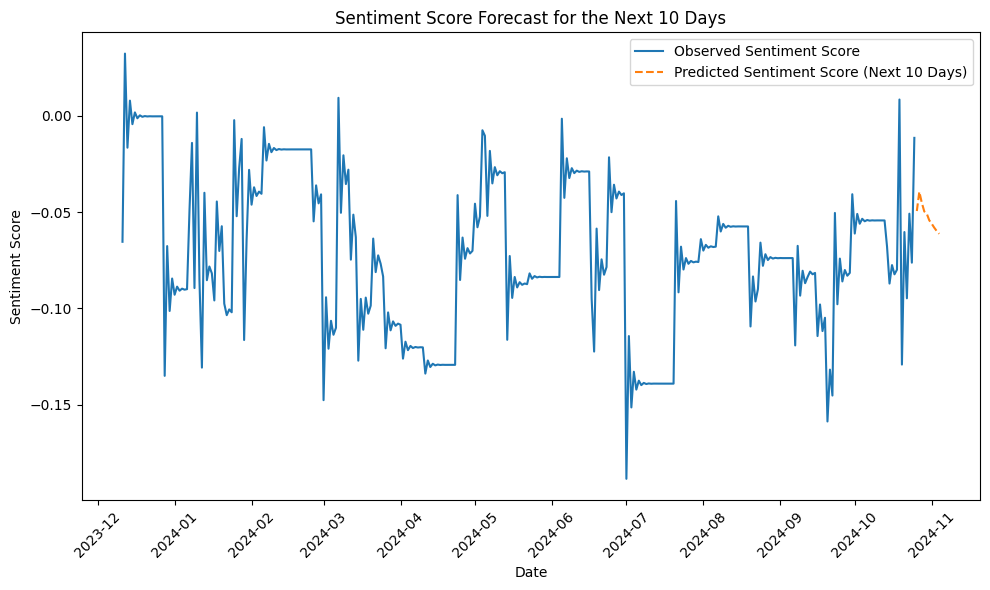

In [ ]:
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

# Set the 'date' as the index
df2.set_index('date', inplace=True)

# Prepare the sentiment scores for autoregression modeling
sentiment_series = df2['sentiment score']

# Fit the AutoReg model
model = AutoReg(sentiment_series, lags=5)
model_fit = model.fit()

# Predict the next 10 days
predictions = model_fit.predict(start=len(sentiment_series), end=len(sentiment_series) + 9)

# Create a DataFrame for predictions with future dates
future_dates = pd.date_range(start=sentiment_series.index[-1] + pd.Timedelta(days=1), periods=10, freq='D')
predictions.index = future_dates  
predictions_df = predictions.reset_index()
predictions_df.columns = ['date', 'predicted_sentiment_score']

# Display the predicted sentiment scores for the next 10 days
print(predictions_df)

# Plot the original sentiment scores and the predictions
plt.figure(figsize=(10, 6))
plt.plot(sentiment_series.index, sentiment_series, label='Observed Sentiment Score')
future_dates = pd.date_range(start=sentiment_series.index[-1] + pd.Timedelta(days=1), periods=10, freq='D')
plt.plot(future_dates, predictions, label='Predicted Sentiment Score (Next 10 Days)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Forecast for the Next 10 Days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
print(df2)

            sentiment score sentiment_label
date                                       
2023-12-11        -0.065391        Negative
2023-12-12         0.032349        Positive
2023-12-13        -0.016521        Negative
2023-12-14         0.007914        Positive
2023-12-15        -0.004304        Negative
...                     ...             ...
2024-10-21        -0.060336        Negative
2024-10-22        -0.094751        Negative
2024-10-23        -0.050802        Negative
2024-10-24        -0.076245        Negative
2024-10-25        -0.011425        Negative

[320 rows x 2 columns]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# the first start date
specific_row = df[df['Date'] == '2023-12-11']

starting_price = specific_row['Close'].iloc[0]
print(starting_price)

df2['close_price'] = np.nan
df2.loc['2023-12-11', 'close_price'] = starting_price

# Start with the first close price on '2023-12-11'
for i in range(1, len(df2)):
    current_date = df2.index[i]
    previous_date = df2.index[i - 1]
    df2.loc[current_date, 'close_price'] = df2.loc[previous_date, 'close_price'] + (4 * df2.loc[previous_date, 'sentiment score'])

print(df2)



248.08
            sentiment score sentiment_label  close_price
date                                                    
2023-12-11        -0.065391        Negative   248.080000
2023-12-12         0.032349        Positive   247.818434
2023-12-13        -0.016521        Negative   247.947830
2023-12-14         0.007914        Positive   247.881744
2023-12-15        -0.004304        Negative   247.913400
...                     ...             ...          ...
2024-10-21        -0.060336        Negative   158.072228
2024-10-22        -0.094751        Negative   157.830883
2024-10-23        -0.050802        Negative   157.451877
2024-10-24        -0.076245        Negative   157.248670
2024-10-25        -0.011425        Negative   156.943690

[320 rows x 3 columns]


In [ ]:
df2 = df2.reset_index()  
print(df2.columns)       


Index(['date', 'sentiment score', 'sentiment_label', 'close_price'], dtype='object')


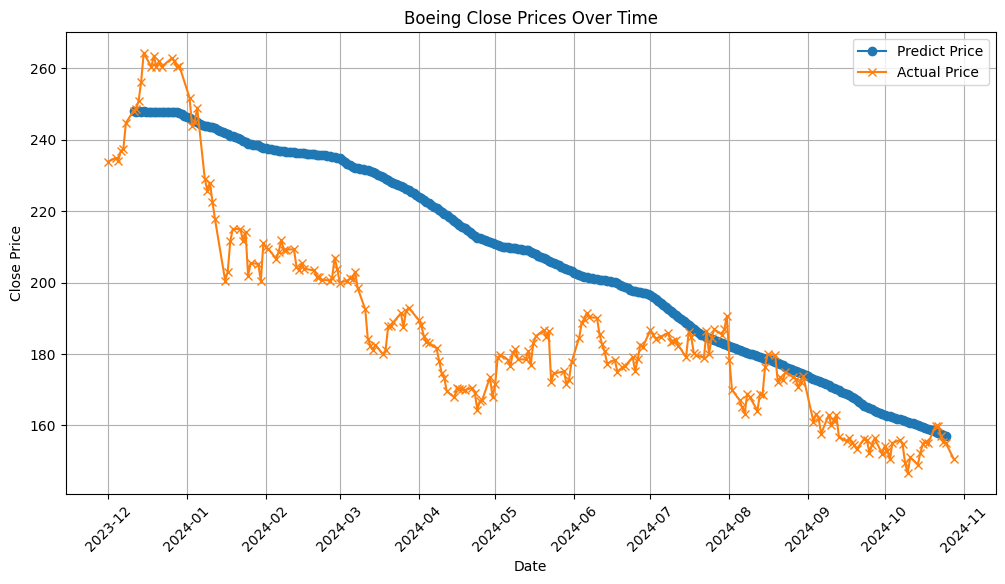

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


df2['date'] = pd.to_datetime(df2['date'])


df['Date'] = pd.to_datetime(df['Date'])

# Plotting both 'date' (df2) and 'Date' (df) with their close prices
plt.figure(figsize=(12, 6))
plt.plot(df2['date'], df2['close_price'], label='Predict Price', marker='o')
plt.plot(df['Date'], df['Close'], label='Actual Price', marker='x')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Boeing Close Prices Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Display the plot
plt.show()
